Mayo 2021
# Maximum Transportation
### Objetivo
Resolver una versión simplificada del problema de airline scheduling, al que llamamos *airport capacity*.

### Descripción del Problema de Optimización

**Airline Scheduling**

La industria aeroespacial es uno de los mercados más grandes y redituables del mundo. En esta industria cada movimiento es muy costoso y se disponen de recursos limitados (cierto número de aviones, pilotos, sobrecargos, vuelos antes del mantenimiento, horarios de despegue y aterrizaje, etc), por lo que deben de ser utilizados de manera eficiente para maximizar las ganancias de la aerolínea. Este es uno de los problemas más importantes de la industria y hasta ahora no tiene solución exacta. Resolver el problema de *airline scheduling* significa obtener un itinerario de los vuelos de la aerolínea en el que el mínimo número de aviones estén volando el mayor tiempo posible. Aquí es donde resulta útil el algoritmo de Ford – Fulkerson para flujo máximo.

**Maximum Transportation**

Este problema es un derivado del problema de *airline scheduling* y no tiene un nombre estándar por lo que lo llamaremos *maximum transportation*. En este caso no nos enfocamos tanto en las aerolíneas en sí, si no en los aeropuertos en los que tienen sede. Se toman en cuenta horarios definidos de despegues y aterrizajes, cantidad de pasajeros por vuelo así como posibles escalas que puedan tenerse para obtener el máximo número de personas que pueden volar de una ciudad a otra con los vuelos actualmente disponibles.

En nuestro caso, para simplificar la resolución del problema asumiremos que todas las escalas son posibles independientemente de las horas de despegue y aterrizaje.

Decimos que se trata de un problema derivado del anterior ya que estamos hablando de restricciones específicas de aviones, si estuvieramos hablando de trenes entonces nos encontrariamos con que el problema de *maximum transportation* es el problema original con el T. E. Harris y F. S. Ross plantearon por primera vez el problema de flujo máximo en su artículo de 1954.


### Decripción del dataset
El dataset a utilizar viene de un repositorio en [github](https://github.com/sid-7/Airline_Maximum_Flow). Originalmente, estos datos fueron obtenidos utilizando la [API](https://api.flightstats.com/flex/schedules/rest/v1/json/from/LAX/to/JFK/departing/2019/1/6) de [flightstats](https://developer.flightstats.com/) pero elegímos utilizar los del repositorio por facilidad ya que se encontraban limpios y en el formato y con los joins que necesitabamos.

El dataset contiene información de los vuelos del 6 enero de 2019 de una cierta aerolínea en Estados Unidos y muestra los registros de sus 565 vuelos de ese día para únicamente 10 aeropuertos. En vez de colocar el nombre explícito del aeropuerto, se muestra su identificador único de 3 letras, a continuación diccionario:

| Identificador | Nombre | Ciudad |
|---------------|--------|--------|
| ATL | Hartsfield-Jackson Atlanta International | Atlanta |
| BOS | Boston-Logan International | Boston |
| DEN | Denver International | Denver |
| IAD | Washington Dulles International | Washington |
| JFK | New York John F. Kennedy International | New York |
| LAX | Los Angeles International | Los Angeles |
| ORD | Chicago O'Hare International | Chicago |
| PHX | Phoenix Sky Harbor International | Phoenix |
| SEA | Seattle-Tacoma International | Seattle |
| SFO | San Francisco International | San Francisco |

El dataset cuenta con cinco columnas:

   + Source: identificador del aeropuerto origen del que sale el vuelo
   + Destination: identificador del aeropuerto destino al que llega el vuelo
   + Departure: hora de despegue del vuelo en el aeropuerto origen en horas militares
   + Arrival: hora de aterrizaje del vuelo en el aeropuerto destino en horas militares
   + capacity: cantidad máxima de pasajeros que puede transportar el vuelo (sin contar al crew)

Además, no presenta ningún valor nulo.



In [1]:
import requests
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from timeit import timeit

In [40]:
url = 'https://raw.githubusercontent.com/sid-7/Airline_Maximum_Flow/master/flights.csv'
df = pd.read_csv(url,index_col=0,parse_dates=[0])

In [41]:
df

Source Destination  Depature  Arrival  capacity
0      ORD         ATL       530      829       185
1      BOS         ATL       545      854       185
2      LAX         SEA       600      900       165
3      PHX         ATL       600     1127       185
4      SFO         ATL       600     1332       230
..     ...         ...       ...      ...       ...
146    BOS         ORD      1330     1533       160
147    BOS         ORD       600      805       160
148    BOS         JFK       601      726       102
149    BOS         JFK      1217     1339       128
150    BOS         JFK       933     1059       160

[565 rows x 5 columns]

In [42]:
data = df.values

## Solución con ffmaxflow
Supongamos que queremos saber el el máximo número de personas que pueden viajar de Denver a Atlanta.

In [5]:
import ffmaxflow as ff

In [6]:
red = ff.create_flow_network()

In [7]:
unique_nodes = np.unique(np.hstack((data[:,0],data[:,1])))
unique_nodes

array(['ATL', 'BOS', 'DEN', 'IAD', 'JFK', 'LAX', 'ORD', 'PHX', 'SEA',
       'SFO'], dtype=object)

In [8]:
for node in unique_nodes:
    
    if node == 'DEN':
        red.create_vertex('{}'.format(node), True, False)
    
    elif node == 'ATL':
        red.create_vertex('{}'.format(node), False, True)
    
    else:
        red.create_vertex('{}'.format(node), False, False)

In [10]:
for row in range(data.shape[0]):
    red.create_edge('{}'.format(data[row,0]), '{}'.format(data[row,1]), data[row,4])

In [11]:
%%time
red.MaxFlow()

CPU times: user 1min 1s, sys: 0 ns, total: 1min 1s
Wall time: 1min 1s


10179

## Solución con ffmaxc

Instalamos el paquete de la reimplementación:

In [12]:
!pip install ../ffmaxc/

Processing /home/diramtz/Documents/Optimizacion/ProyectoFinal_MaxFlow/ffmaxc
  Created wheel for UNKNOWN: filename=UNKNOWN-0.0.0-cp38-cp38-linux_x86_64.whl size=250166 sha256=f8a7122f23e6dcd43713458b9f33677cd70853e129c4c7f020c1e7d5410ea1f1
  Stored in directory: /tmp/pip-ephem-wheel-cache-g7i8kfz7/wheels/64/ec/00/07fbc8f81d14bd6e084a678ffbbd60843bf4aaa867d0489e69
Successfully built UNKNOWN
  Attempting uninstall: UNKNOWN
    Found existing installation: UNKNOWN 0.0.0
    Uninstalling UNKNOWN-0.0.0:
      Successfully uninstalled UNKNOWN-0.0.0


In [13]:
import ffmaxc as ffc

Creamos la red y encontramos los nodos únicos:

In [14]:
red = ffc.create_flow_network()

In [15]:
unique_nodes = np.unique(np.hstack((data[:,0],data[:,1])))
unique_nodes

array(['ATL', 'BOS', 'DEN', 'IAD', 'JFK', 'LAX', 'ORD', 'PHX', 'SEA',
       'SFO'], dtype=object)

In [16]:
for node in unique_nodes:
    
    if node == 'DEN':
        red.create_vertex('{}'.format(node), True, False)
    
    elif node == 'ATL':
        red.create_vertex('{}'.format(node), False, True)
    
    else:
        red.create_vertex('{}'.format(node), False, False)

Definimos los arcos:

In [18]:
for row in range(data.shape[0]):
    red.create_edge('{}'.format(data[row,0]), '{}'.format(data[row,1]), data[row,4])

In [19]:
%%time
red.MaxFlow()

CPU times: user 59.1 s, sys: 103 ms, total: 59.2 s
Wall time: 59.2 s


10179.0

## Solución con networkx

Ahora con ayuda de la paquetería de networkx comprobamos que nuestros paquetes den el resultado correcto.

In [20]:
G = nx.DiGraph()

In [21]:
for row in range(data.shape[0]):
    G.add_edge('{}'.format(data[row,0]), '{}'.format(data[row,1]), capacity = data[row,2])

In [22]:
flow_value, flow_dict = nx.maximum_flow(G, 'DEN', 'ATL')

In [23]:
flow_value

9638

Notamos que el resultado devuelto por networks no se parece en nada al que arrojaron nuestros paquetes, de hecho ni siquiera tiene el mismo orden de magnitud.

Después de investigar un poco, dimos con el problema. Cuando tienes varios arcos entre un par específico de nodos, al definir el arco utilizamos los mismo nombres de estos dos nodos una y otra vez. La diferencia entre `ffmaxflow` y `networkx` es que `ffmaxflow` guarda cada uno de estos vértices de manera independiente, sin importar que sus parámetros sean los mismos, mientras que `networkx` sobrescribe cada arco que llama a un par de nodos que ya se tenían guardados bajo otro arco.

Entonces, si sumamos todas las capacidades (cantidad de pasajeros) por ruta y metemos esta nueva red resumida a `networkx` deberíamos de obtener el mismo resultado que con `ffmaxflow`.

### Sumando todos los pasajeros de la ruta

In [43]:
suma_df = df.groupby(['Source', 'Destination'])['capacity'].sum().reset_index()
suma_df

Source Destination  capacity
0     ATL         BOS      2035
1     ATL         DEN      1440
2     ATL         IAD       884
3     ATL         JFK      1350
4     ATL         ORD      2235
..    ...         ...       ...
67    SFO         IAD       760
68    SFO         JFK       102
69    SFO         ORD      1930
70    SFO         PHX      1254
71    SFO         SEA      2290

[72 rows x 3 columns]

In [44]:
new_data = suma_df.values

In [45]:
G = nx.DiGraph()

In [46]:
for row in range(new_data.shape[0]):
    G.add_edge('{}'.format(new_data[row,0]), '{}'.format(new_data[row,1]), capacity = new_data[row,2])

In [47]:
flow_value, flow_dict = nx.maximum_flow(G, 'DEN', 'ATL')

In [48]:
flow_value

10179

Y ahora sí, vemos que se obtuvo el mismo resultado que con `ffmaxflow` y `ffmaxc`, por lo que nuestra  implementación es correcta.

## Gráfica de las rutas

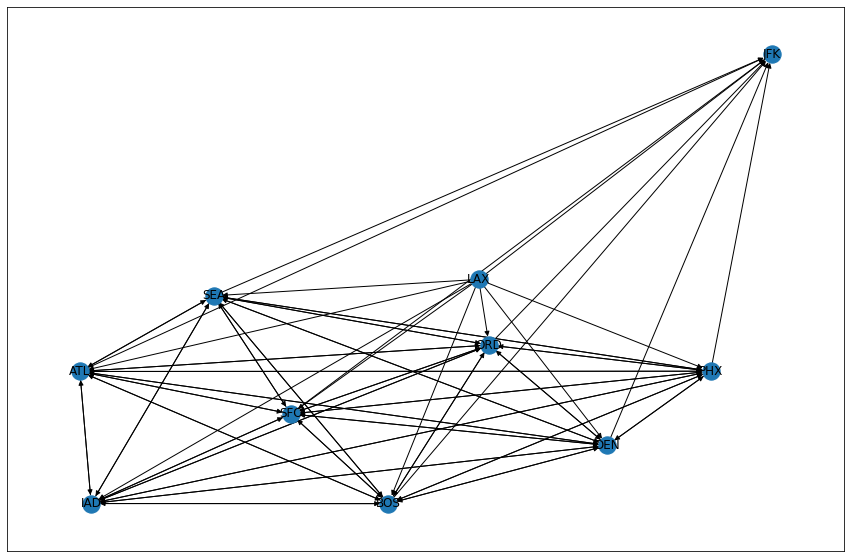

In [36]:
plt.figure(figsize = (15,10))
nx.draw_networkx(G)

## Función
También podemos crear una función para que sea más fácil y rápido calcular el máximo flujo de pasajeros de un aeropuerto a otro.

In [37]:
def calculate_flow(source_airport, destiny_airport, data):
    
    red = ff.create_flow_network()
    unique_nodes = np.unique(np.hstack((data[:,0],data[:,1])))
    
    for node in unique_nodes:
    
        if node == source_airport:
            red.create_vertex('{}'.format(node), True, False)
    
        elif node == destiny_airport:
            red.create_vertex('{}'.format(node), False, True)
    
        else:
            red.create_vertex('{}'.format(node), False, False)
        
    for row in range(data.shape[0]):
        red.create_edge('{}'.format(data[row,0]), '{}'.format(data[row,1]), data[row,4])
    
    return red.MaxFlow()

In [38]:
def calculate_flowc(source_airport, destiny_airport, data):
    
    red = ffc.create_flow_network()
    unique_nodes = np.unique(np.hstack((data[:,0],data[:,1])))
    
    for node in unique_nodes:
    
        if node == source_airport:
            red.create_vertex('{}'.format(node), True, False)
    
        elif node == destiny_airport:
            red.create_vertex('{}'.format(node), False, True)
    
        else:
            red.create_vertex('{}'.format(node), False, False)
        
    for row in range(data.shape[0]):
        red.create_edge('{}'.format(data[row,0]), '{}'.format(data[row,1]), data[row,4])
    
    return red.MaxFlow()

## Ejemplos

+ De Denver a Atlanta

In [49]:
%%time
calculate_flow('DEN', 'ATL', data)

CPU times: user 58.9 s, sys: 6.18 ms, total: 58.9 s
Wall time: 58.9 s


10179

In [50]:
%%time
calculate_flowc('DEN', 'ATL', data)

CPU times: user 57.4 s, sys: 132 ms, total: 57.5 s
Wall time: 57.3 s


10179.0

+ De Boston a Seattle

In [51]:
%%time
calculate_flow('BOS', 'SEA', data)

CPU times: user 1min 24s, sys: 14.3 ms, total: 1min 24s
Wall time: 1min 28s


7374

In [52]:
%%time
calculate_flowc('BOS', 'SEA', data)

CPU times: user 1min 23s, sys: 263 ms, total: 1min 23s
Wall time: 1min 34s


7374.0

+ De Washington a Phoenix

In [53]:
%%time
calculate_flow('IAD', 'PHX', data)

CPU times: user 6min 15s, sys: 69.9 ms, total: 6min 15s
Wall time: 6min 50s


5492

In [54]:
%%time
calculate_flowc('IAD', 'PHX', data)

CPU times: user 6min 16s, sys: 1.13 s, total: 6min 18s
Wall time: 7min 29s


5492.0

+ De San Francisco a Atlanta

In [55]:
%%time
calculate_flow('SFO', 'ATL', data)

CPU times: user 2min 13s, sys: 62.6 ms, total: 2min 13s
Wall time: 2min 47s


10352

In [56]:
%%time
calculate_flowc('SFO', 'ATL', data)

CPU times: user 2min 7s, sys: 344 ms, total: 2min 7s
Wall time: 2min 26s


10352.0

### Tabla de Tiempos para viaje de Denver a Atlanta con timeit
En los ejemplos anteriores medimos el tiempo de ejecución tanto del paquete original como de la reimplementación, sin embargo una sóla medición tiende a ser ruidosa ya que a veces se toman en cuenta procesos que corren en el fondo. Una mejor medición sería hacer el promedio de varias mediciones con ayuda de `timeit`.

**ffmaxflow**

In [5]:
setup_code = """import ffmaxflow as ff
import numpy as np
import pandas as pd
                
url = 'https://raw.githubusercontent.com/sid-7/Airline_Maximum_Flow/master/flights.csv'
df = pd.read_csv(url,index_col=0,parse_dates=[0])
data = df.values
    
"""

statement = """
red = ff.create_flow_network()
unique_nodes = np.unique(np.hstack((data[:,0],data[:,1])))
           
for node in unique_nodes: 
    if node == 'DEN':
        red.create_vertex('{}'.format(node), True, False)
    
    elif node == 'ATL':
        red.create_vertex('{}'.format(node), False, True)
    
    else:
        red.create_vertex('{}'.format(node), False, False)
                    
for row in range(data.shape[0]):
    red.create_edge('{}'.format(data[row,0]), '{}'.format(data[row,1]), data[row,4])
            
red.MaxFlow()  
            
"""

print (timeit(setup = setup_code, stmt = statement, number = 10)) 

641.4799938199976


In [10]:
print("Tiempo promedio de una ejecución: {} segundos".format(641.4799/10))

Tiempo promedio de una ejecución: 64.14799000000001 segundos


**ffmaxc**

In [4]:
setup_code = """import ffmaxc as ffc
import numpy as np
import pandas as pd
                
url = 'https://raw.githubusercontent.com/sid-7/Airline_Maximum_Flow/master/flights.csv'
df = pd.read_csv(url,index_col=0,parse_dates=[0])
data = df.values
    
"""

statement = """
red = ffc.create_flow_network()
unique_nodes = np.unique(np.hstack((data[:,0],data[:,1])))
           
for node in unique_nodes: 
    if node == 'DEN':
        red.create_vertex('{}'.format(node), True, False)
    
    elif node == 'ATL':
        red.create_vertex('{}'.format(node), False, True)
    
    else:
        red.create_vertex('{}'.format(node), False, False)
                    
for row in range(data.shape[0]):
    red.create_edge('{}'.format(data[row,0]), '{}'.format(data[row,1]), data[row,4])
            
red.MaxFlow()  
            
"""

print (timeit(setup = setup_code, stmt = statement, number = 10)) 

566.4257510969983


In [12]:
print("Tiempo promedio de una ejecución: {} segundos".format(566.4257/10))

Tiempo promedio de una ejecución: 56.64257 segundos


**networkx**

In [8]:
setup_code = """import networkx as nx
import numpy as np
import pandas as pd
                
url = 'https://raw.githubusercontent.com/sid-7/Airline_Maximum_Flow/master/flights.csv'
df = pd.read_csv(url,index_col=0,parse_dates=[0])
sum = df.groupby(['Source', 'Destination'])['capacity'].sum().reset_index()
new_data = sum.values
    
"""

statement = """
G = nx.DiGraph()

for row in range(new_data.shape[0]):
    G.add_edge('{}'.format(new_data[row,0]), '{}'.format(new_data[row,1]), capacity = new_data[row,2])

flow_value, flow_dict = nx.maximum_flow(G, 'DEN', 'ATL')
            
"""

print (timeit(setup = setup_code, stmt = statement, number = 10)) 

0.020034563000081107


In [13]:
print("Tiempo promedio de una ejecución: {} segundos".format(0.0200/10))

Tiempo promedio de una ejecución: 0.002 segundos


La tabla de tiempos resulta entonces:

| Paquete | Resultado | Tiempo de ejecución promedio |
|--------|-----------|---------------------|
| ffmaxflow | 10179 | 64 s |
| ffmaxc | 10179.0 | 56 s |
| networkx | 10179 | 0.002 |

## Referencias
+ [Airline Scheduling with Max Flow algorithm](http://ilab-australia.org/jms/wp-content/uploads/2018/09/28.-P.ICT_.012.pdf)
+ [Maximum Flow Problem](https://en.wikipedia.org/wiki/Maximum_flow_problem)
+ [Airport Capacity Profiles](https://www.faa.gov/airports/planning_capacity/profiles/)